In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import (
    TimeContinuousMarkovChainQueueModel,
    infra_lambda,
    infra_cost,
    total_variation,
    operation_profit
)
import seaborn as sns
from functools import partial
from typing import Dict, List, Any
import pandas as pd

In [ ]:
producer_lambda = 1000
queue_size = 100
discrete_time_step = 0.01
base_price = 1
multiplier = np.arange(5)
operation_cost = 1*2*multiplier
base_lambda = 500
machines_lambda = base_lambda*2.1*multiplier
customer_revenue=0.01
wait_time_cost=0.01
start_machines = np.array([0, 1, 0, 0, 1])
consumer_lambda = infra_lambda(
    machines=start_machines,
    machines_lambda=machines_lambda,
)
producer_lambda_increase = 2*producer_lambda

new_machines = 2*start_machines
increase_response_time = 120

In [ ]:
get_profit = partial(
    operation_profit,
    customer_revenue=customer_revenue,
    wait_time_cost=wait_time_cost
)
get_infra_cost = partial(
    infra_cost,
    operation_cost=operation_cost,
)
get_infra_lambda = partial(
    infra_lambda,
    machines_lambda=machines_lambda
)

def get_integrated_cost(increase_response_time, queue_size):
    
    

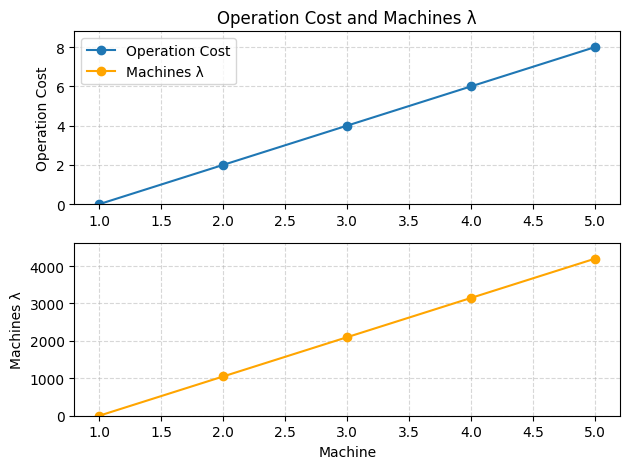

In [3]:
fig, axes = plt.subplots(2, 1)
for ax in axes:
    ax.grid(linestyle='--', alpha=0.5)
x = np.arange(1, len(operation_cost) + 1)
lines = axes[0].plot(x, operation_cost, marker='o', label='Operation Cost')
lines += axes[1].plot(
    x, machines_lambda, marker='o', color='orange', label='Machines λ'
)
axes[0].legend(lines, [l.get_label() for l in lines])
axes[0].set(
    title='Operation Cost and Machines λ',
    ylabel='Operation Cost',
    ylim=(0, 1.1*max(operation_cost))
)
axes[1].set(
    ylabel='Machines λ',
    ylim=(0, 1.1*max(machines_lambda)),
    xlabel='Machine'
    # ylim=ax.get_ylim(),
)
# axis_rates = max(machines_lambda) / max(operation_cost) 
# # twinx_yticks = np.arange(0, )
# twinx.set_yticks(np.linspace(0, 1.1*max(machines_lambda), len(ax.get_yticks())))
fig.tight_layout()

In [ ]:
queue_model = TimeContinuousMarkovChainQueueModel(
    producer_lambda=producer_lambda,
    consumer_lambda=consumer_lambda,
    size=queue_size,
    time_step=discrete_time_step
)

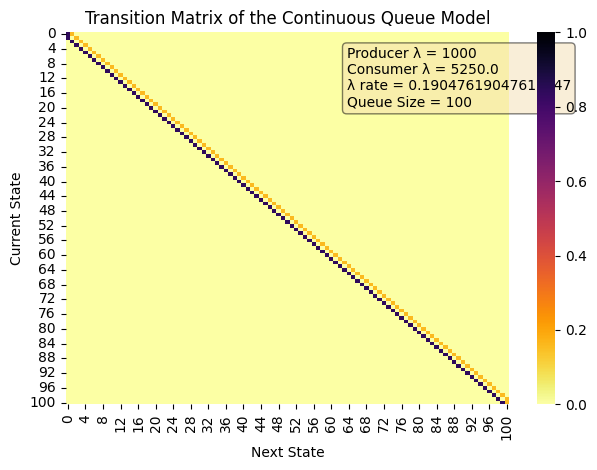

In [5]:
fig, ax = plt.subplots()
sns.heatmap(queue_model.transition_matrix,
            annot=False,
            cmap='inferno_r',
            fmt=".2f",
            ax=ax,
            vmin=0, vmax=1)
ax.set_title('Transition Matrix of the Continuous Queue Model')
textstr = (
    f'Producer λ = {producer_lambda}\n'
    f'Consumer λ = {consumer_lambda}\n'
    f'λ rate = {queue_model.lambda_rate}\n'
    f'Queue Size = {queue_size}'
)
ax.text(64, 4,
        textstr,
        verticalalignment='top',
        bbox=dict(
            boxstyle='round', facecolor='wheat', alpha=0.5
        ))
ax.set_ylabel('Current State')
ax.set_xlabel('Next State')
fig.tight_layout()

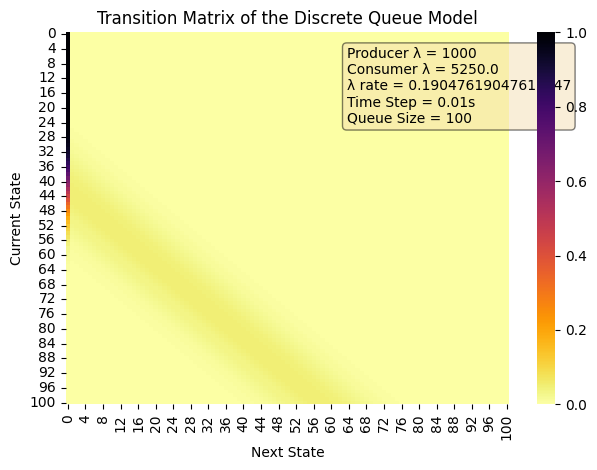

In [6]:
fig, ax = plt.subplots()
sns.heatmap(queue_model.discrete.transition_matrix,
            annot=False,
            cmap='inferno_r',
            fmt=".2f",
            ax=ax,
            vmin=0, vmax=1)
ax.set_title('Transition Matrix of the Discrete Queue Model')
textstr = (
    f'Producer λ = {producer_lambda}\n'
    f'Consumer λ = {consumer_lambda}\n'
    f'λ rate = {queue_model.lambda_rate}\n'
    f'Time Step = {discrete_time_step}s\n'
    f'Queue Size = {queue_size}'
)
ax.text(64, 4,
        textstr,
        verticalalignment='top',
        bbox=dict(
            boxstyle='round', facecolor='wheat', alpha=0.5
        ))
ax.set_ylabel('Current State')
ax.set_xlabel('Next State')
fig.tight_layout()

In [ ]:
def execute_step(
    markov_chain_model, 
    costs: List[float],
    fail_probs: List[float],
    states_distributions: List[float],
    efective_lambdas: List[float],
    integrated_costs: List[float],
    total_variations: List[float],
):
    new_distribution = markov_chain_model.discrete.get_distribution(states_distributions[-1])
    fail_prob = new_distribution[-1]
    fail_probs.append(fail_prob)
    states_distributions.append(new_distribution)
    efective_lambdas.append(queue_model.producer_lambda)
    costs.append(cost)
    integrated_costs.append(cost * discrete_time_step)
    total_variations.append(total_variation(
        current_distribution,
        queue_model.discrete.stationary_distribution
    ))

def get_step_values(
    current_distribution: np.ndarray,
    stationary_distribution: np.ndarray,
    producer_lambda: float,
    consumer_lambda: float,
    queue_size: int,
):
    fail_prob = current_distribution[-1]
    expected_size = np.dot(np.arange(queue_size + 1), current_distribution)
    effective_producer_lambda = producer_lambda * (1 - fail_prob)
    total_variation_value = total_variation(
        current_distribution,
        stationary_distribution
    )
    profit = get_profit(
        effective_producer_lambda,
        consumer_lambda,
        expected_size
    )
    return profit, current_distribution, fail_prob, expected_size, effective_producer_lambda, total_variation_value

In [ ]:
current_distribution = queue_model.stationary_distribution
costs=[]
fail_probs=[]
states_distributions=[]
effective_producer_lambdas=[]
integrated_costs=[]
total_variations=[]
cost, distribution, fail_prob, effective_producer_lambda, total_variation_value = get_step_values(
    current_distribution
)
costs.append(cost)
fail_probs.append(fail_prob)
states_distributions.append(distribution)
effective_producer_lambdas.append(effective_producer_lambda)
integrated_costs.append(cost * discrete_time_step)
total_variations.append(total_variation(
    current_distribution,
    queue_model.discrete.stationary_distribution
))

cooldown = 30
current_step = 1
epsilon = 1e-2

transition_model = TimeContinuousMarkovChainQueueModel(
    producer_lambda=producer_lambda,
    consumer_lambda=consumer_lambda,
    size=queue_size,
    time_step=discrete_time_step
)
queue_model

while cooldown < current_step and total_variations[-1] > epsilon:
    time = current_step * discrete_time_step
    if time > increase_response_time:
        queue_model.producer_lambda = producer_lambda_increase
        queue_model.consumer_lambda = get_infra_lambda(new_machines)
        cost = get_infra_cost(new_machines)
    else:
        queue_model.producer_lambda = producer_lambda
        queue_model.consumer_lambda = consumer_lambda
        cost = get_infra_cost(start_machines)
    execute_step(
        transition_matrix,
        stationary_distribution,
        current_step,
        costs,
        fail_probs,
        states_distributions,
        efective_lambdas,
        integrated_costs,
        total_variations
    )
    current_step += 1